In [1]:
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/tmp/ipykernel_67326/2173042773.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
fps = sorted(list(Path('/data/nga/Oliktok/').rglob('*.cor')))

In [3]:
def dem_to_np(fp):
    par_fp = fp.parent.parent.joinpath('processing', fp.stem + ('.diff_par'))
    with open(par_fp, 'r') as f:
        lns = f.readlines()
    par = {l.split()[0]:l.split()[1] for l in lns if len(l.split()) == 2}
    arr = np.fromfile(fp, '>f4').reshape(int(par['az_samp_1:']), int(par['range_samp_1:']))
    return arr

def cor_to_np(fp):
    with open(fp.with_suffix('.diff_par'), 'r') as f:
        lns = f.readlines()
    par = {l.split()[0]:l.split()[1] for l in lns if len(l.split()) == 2}
    par = dict({(k, float(v)) for k,v in par.items()})
    arr = np.fromfile(fp, '>f4').reshape(int(par['interferogram_azimuth_lines:']), int(par['interferogram_width:']))
    return arr

In [4]:
df = pd.DataFrame(fps, columns = ['fp'])
df.loc[:, 'Location'] = df['fp'].astype(str).str.split('/').map(lambda x: x[3])

df.loc[:, 'Orbit'] = df['fp'].astype(str).str.split('/').map(lambda x: x[4])

df.loc[:, 'Date1'] = df['fp'].astype(str).str.split('/').map(lambda x: x[5].split('_')[0])
df.loc[:, 'Date2'] = df['fp'].astype(str).str.split('/').map(lambda x: x[5].split('_')[1])

df.loc[:, 'Temporal Baseline'] = pd.to_datetime(df['Date2']) - pd.to_datetime(df['Date1'])

def ave_cor(f):
    dates = f.stem.split('_')
    dates = [pd.to_datetime(d) for d in dates]

    arr = cor_to_np(f)
    wm = dem_to_np(f.parent.parent.joinpath('processing', str(dates[0].date())).with_suffix('.hgt')) > 20
    arr[~wm] = np.nan
    return np.round(np.nanmean(arr), 2)

df['Ave Coherence'] = df['fp'].map(ave_cor)

def quant_cor(f):
    dates = f.stem.split('_')
    dates = [pd.to_datetime(d) for d in dates]

    arr = cor_to_np(f)
    wm = dem_to_np(f.parent.parent.joinpath('processing', str(dates[0].date())).with_suffix('.hgt')) > 20
    arr[~wm] = np.nan
    return np.round(np.nanquantile(arr, [0.25, 0.75]), 2)

df['IQR Coherence'] = df['fp'].map(quant_cor)

df = df.drop('fp', axis = 1)

/tmp/ipykernel_67326/3224768729.py:18: RuntimeWarning: Mean of empty slice
  return np.round(np.nanmean(arr), 2)
/home/ubuntu/miniconda3/envs/science/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


In [7]:
df

,Location,Orbit,Date1,Date2,Temporal Baseline,Ave Coherence,IQR Coherence
0,Oliktok,SLA16,2023-06-16,2023-07-10,24 days,0.13,"[0.04, 0.17]"
1,Oliktok,SLA16,2023-06-16,2023-08-03,48 days,0.08,"[0.03, 0.1]"
2,Oliktok,SLA16,2023-06-16,2023-08-27,72 days,0.08,"[0.03, 0.1]"
3,Oliktok,SLA16,2023-06-16,2023-09-20,96 days,0.08,"[0.02, 0.1]"
4,Oliktok,SLA16,2023-07-10,2023-08-03,24 days,0.14,"[0.1, 0.18]"
5,Oliktok,SLA16,2023-07-10,2023-08-27,48 days,0.10,"[0.03, 0.12]"
6,Oliktok,SLA16,2023-07-10,2023-09-20,72 days,0.10,"[0.03, 0.15]"
7,Oliktok,SLA16,2023-08-03,2023-08-27,24 days,0.09,"[0.04, 0.11]"
8,Oliktok,SLA16,2023-08-03,2023-09-20,48 days,0.08,"[0.03, 0.09]"
9,Oliktok,SLA16,2023-08-27,2023-09-20,24 days,0.25,"[0.14, 0.35]"


Text(0.5, 1.0, 'Oliktok Coherence Decay vs Temporal Baseline')

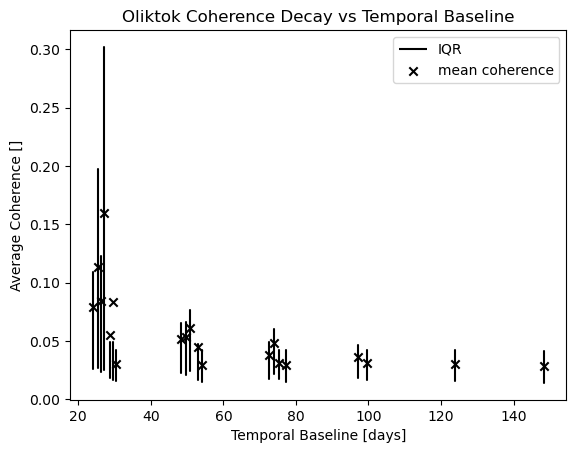

In [27]:
for i, f in enumerate(fps):
    dates = f.stem.split('_')
    dates = [pd.to_datetime(d) for d in dates]

    arr = cor_to_np(f)
    wm = dem_to_np(f.parent.parent.joinpath('processing', str(dates[0].date())).with_suffix('.hgt')) > -2
    # arr[~wm] = np.nan
    dt = dates[1] - dates[0]
    quantiles = np.nanquantile(arr, [0.25, 0.75])
    plt.scatter(dt.days + i/3, np.nanmean(arr), color = 'black', marker = 'x')
    plt.vlines(dt.days + i/3, *quantiles, color = 'black',  capstyle='round')
    # plt.annotate(str(i), [dt.days + 3, quantiles[1]+0.1])
plt.vlines([], [], [], color = 'black', label = 'IQR')
plt.scatter([], [], marker='x', color = 'black', label = 'mean coherence')
plt.legend()
plt.ylabel('Average Coherence []')
plt.xlabel('Temporal Baseline [days]')
plt.title('Oliktok Coherence Decay vs Temporal Baseline')

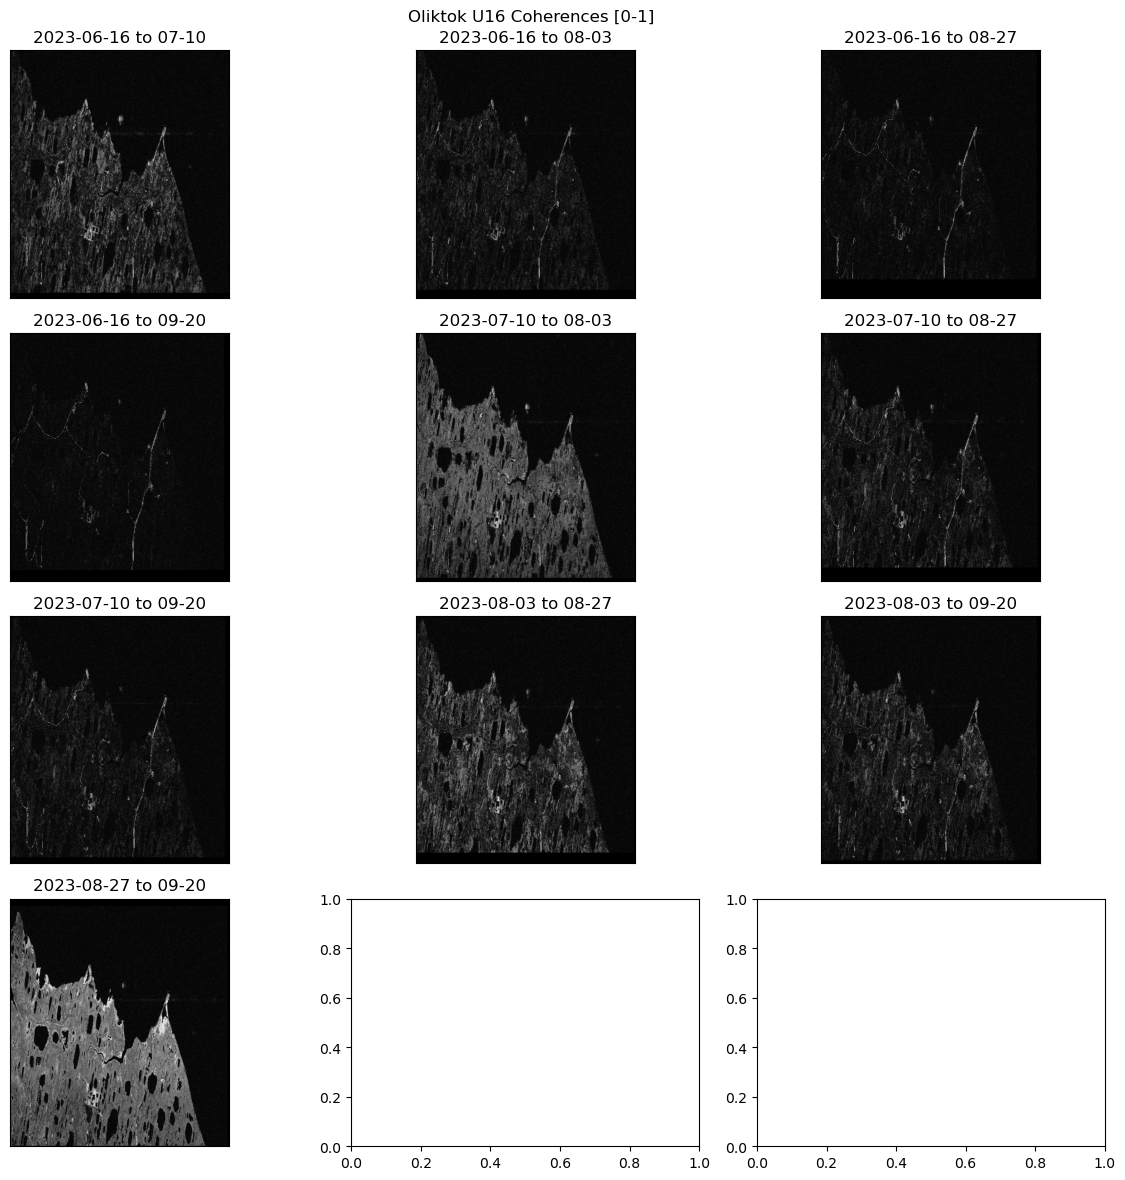

In [26]:
u_18fps = sorted(list(Path('/data/nga/Oliktok/SLA16').rglob('*.cor')))
import math
cols = 3
rows = math.ceil(len(u_18fps)/cols)

fig, axes = plt.subplots(rows, cols , figsize = (12, 12), gridspec_kw={})
for f, ax in zip(u_18fps, axes.ravel()):
    # if f.parent.parent.parent.stem == 'U18': continue
    dates = f.stem.split('_')
    dates = [pd.to_datetime(d) for d in dates]

    arr = cor_to_np(f)
    # wm = dem_to_np(f.parent.parent.joinpath('processing', str(dates[0].date())).with_suffix('.hgt')) > -2
    # arr[~wm] = np.nan
    im = ax.imshow(arr, vmin = 0, vmax = 1, cmap = 'Greys_r')
    ax.set_title(f"{dates[0].date()} to {dates[1].date().strftime('%m-%d')}")
    ax.set_xticks([])
    ax.set_yticks([])

# gs = fig.add_gridspec(cols, rows+1)
# fig.add_subplot(gs[:, -1])
# plt.colorbar(im,fraction=0.046, pad=0.04)
plt.suptitle('Oliktok U16 Coherences [0-1]')
plt.tight_layout()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


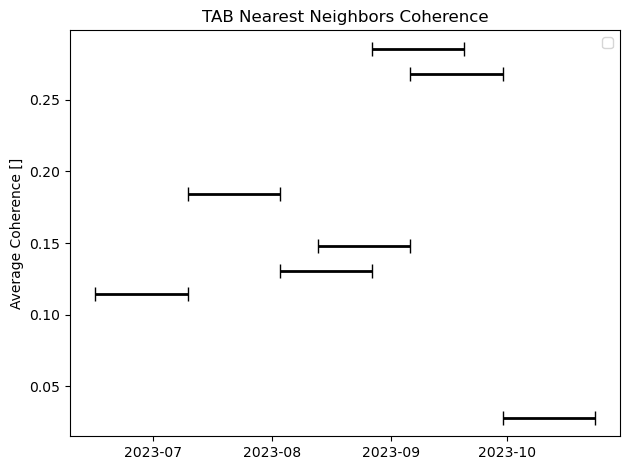

In [28]:
import matplotlib.dates as mdates
for i, f in enumerate(fps):
    dates = f.stem.split('_')
    dates = [pd.to_datetime(d) for d in dates]
    dt = dates[1] - dates[0]
    if dt.days > 26: continue



    arr = cor_to_np(f)
    wm = dem_to_np(f.parent.parent.joinpath('processing', str(dates[0].date())).with_suffix('.hgt')) > -2
    arr[~wm] = np.nan
    d1, d2 = dates
    mid_date = d1 + (d2 - d1)/2
    plt.errorbar([mid_date], [np.nanmean(arr)], xerr = [(d2-d1)/2], color = 'black', linewidth = 2, linestyle = 'dashed', capsize = 5)
    # plt.plot([dates[0], dates[1]], [np.nanmean(arr), np.nanmean(arr)], color = 'black', linewidth = 3)
plt.legend()
plt.ylabel('Average Coherence []')
plt.xlabel('')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.title('TAB Nearest Neighbors Coherence')
plt.tight_layout()